# Supervised ML - classification

### What we learned from the EDA:

* Customers with a low tenure are more likely to churn
* Most customers who churn pay month-to-month (hand in hand with previous find)
* Customers who churn later on tend to have a higher monthly bill
* Customers are more likely to churn if they have a fiber optic service
* Customers who do not have internet service are likely to churn

### Based on these findings alone, one could argue for...

1. Incentivize customers to sign on for longer subscriptions.
2. Fiber optic service/provision needs seeing over. Are customers moving to competitors due to pricing, poor quality or both?
3. Incentivize package deals. Provide further encouragement for customers to sign on for both phone and internet.

Furthermore, we have grouped our customers, infering more information. We have identified 2 distinct groups of customers that are more likely to churn than others. These groups...

* Are less likely to have a partner
* Are less likely to have a dependent
* Are less likely to have phone service
* Are more likely to have a DSL connection than fiber optic
* Are less likely to have any kind of additional service package (backup, security etc.)
* One of these groups is less likely to have any form of streaming service
* Are more likely have a month-to-month contract (they can opt out more easily)
* One of these groups is less likely to pay online

This is all good and well. We could take a customer and run them through our clustering algorithm and already have a pretty good idea of if they are going to churn/retain. Let's go one step further though.

### Now, finally, we will move on to supervised classification

We will...

* Import our data
* Split it into a train and test set
* Remove customer ID's and later infer these (they are unique for each customer and will only serve to increase noise)
* Perform a cross fold evaluation to decide which classification model best suits our data
    - We will evaluate models based on **recall**. We select this scoring metric since we want a model thatdetects as many churns as possible. Since most customers who churn do so early on, there is a huge loss (in terms of LTV) for most of our churned customers. Much is to be gained by retaining them.
* Perform feature optimization on the most promising model
    - Scoring will once again be based on **recall**, since we want to maximize the amount of detected churns.
        - Note: choosing recall is advantageous because we have previously identified several metrics (like contract term, tenure, services etc.) that can be used to 'manually' cross-check a churn-flagged customer. The idea here is it is **far more** important to catch a churning customer than to mistakenly offer incetives one who we would retain regardless.
* Further enhance the model by performing hyperparameter-tuning
* Fit the model to our training data
* Final evaluation on our test data

The overall idea here is to create a model that will raise flags for us. We can then use this in conjunction with the results from our manual EDA and unsupervised classification to retain as many customers as possible. The strongest argument for this is that **most of** our churned customers leave at an early phase. We miss **a lot** of potential revenue here.

Once a model has been selected, it will also be evaluated on F1 and precision. This will be relevant in order to discuss costs associated with false positives and monitoring (if needed) of the implemented model.

___
# Imports & settings

In [52]:
# Imports

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Paths

# Note : In order to run this code on your machine, make sure the path variable is correct.

path = 'C:\\Users\\victo\\00_Nod_coding_bootcamp\\Week 10\\Project_Telco_churn'
os.chdir(path)
figures = path + '\\Figures\\KMeans\\'
data = path + '\\Data\\'

In [53]:
# Figure settings

fig_size = (24,16)
title_size = 30
label_size = 25
tick_size = 20
sns.set_style("darkgrid")
sns.set_palette("Paired")

___
# Data

In [54]:
df = pd.read_csv(data + 'WA_Fn-UseC_-Telco-Customer-Churn_CLUSTERS.csv')
df.drop(columns = ["customerID", "Unnamed: 0"], inplace = True)
df.reset_index(drop = True, inplace = True)
target = 'Churn'
X = df.drop(columns = target)
y = df[target]

#### Split data

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

___
# Preprocessing

In [56]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

In [57]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop = "if_binary")

num_cols = make_column_selector(dtype_include = "number")
cat_cols = make_column_selector(dtype_include = "object")

preprocessing = make_column_transformer((scaler, num_cols),
                                        (encoder, cat_cols))

# Evaluation with `GridSearchCV`

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

classifiers = [LogisticRegression(max_iter = 1000),
               DecisionTreeClassifier(random_state = 42),
               RandomForestClassifier(random_state = 42),
               SVC(random_state = 42),
               KNeighborsClassifier()]

In [59]:
from sklearn.model_selection import GridSearchCV
scoring = ['recall',
           'precision',
           'accuracy',
           'f1',
           'roc_auc']

for k in scoring:
    print(f"-----------------------------{k}-----------------------------\n\n")
    for i in classifiers:

        pipe = make_pipeline(preprocessing, i)
        grid = GridSearchCV(estimator = pipe, 
                            cv = 10,
                            scoring = k,
                            param_grid = {})


        grid.fit(X_train, y_train)
        print(f"{k}-score for {i}:\n{round(grid.best_score_,5)}\n\n")

-----------------------------recall-----------------------------


recall-score for LogisticRegression(max_iter=1000):
0.53022


recall-score for DecisionTreeClassifier(random_state=42):
0.49928


recall-score for RandomForestClassifier(random_state=42):
0.47194


recall-score for SVC(random_state=42):
0.46403


recall-score for KNeighborsClassifier():
0.52014


-----------------------------precision-----------------------------


precision-score for LogisticRegression(max_iter=1000):
0.65358


precision-score for DecisionTreeClassifier(random_state=42):
0.49116


precision-score for RandomForestClassifier(random_state=42):
0.61402


precision-score for SVC(random_state=42):
0.66359


precision-score for KNeighborsClassifier():
0.54541


-----------------------------accuracy-----------------------------


accuracy-score for LogisticRegression(max_iter=1000):
0.80196


accuracy-score for DecisionTreeClassifier(random_state=42):
0.73097


accuracy-score for RandomForestClassifier(random_

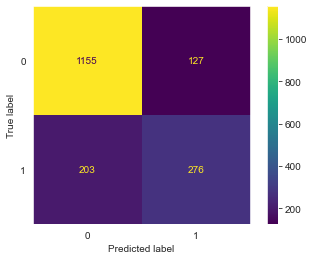

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pipe = make_pipeline(preprocessing, LogisticRegression(max_iter=1000))
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
M = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(M).plot()
plt.grid(None)

### Model evaluation

Based on the cross fold evaluation, we will move on with a logistic regression classifier model.

# Tuning the LogReg-model

First, we will perform feature selection. We will do this by concidering all possible combinations.

In [61]:
import itertools

cols = list(X_train.columns)
combinations = {}

for i in range(1, len(cols)+1):
    combinations[i] = list(itertools.combinations(cols, r = i))
    
count = 0

for i in combinations.keys():
    count += len(combinations[i])
print("There are a total of", count, "combinations!")

There are a total of 1048575 combinations!


### 10487575 combinations

Is quite a lot to consider!

As it turns out, running this optimization takes _**EXTREMELY**_ long. Instead, lets look at the coefficients for the model when we train it on all available features. We will run the optimization over night and see how it turns out bur for now lets do it the simpler way.

# Check the coefficients

In [62]:
pipe = make_pipeline(RobustScaler(), LogisticRegression(max_iter = 1000))
X_train_dummy = pd.get_dummies(X_train, drop_first = True)
pipe.fit(X_train_dummy, y_train)
coefs = pipe[1].coef_[0]

In [63]:
import numpy as np
feat_imp = list(zip(coefs, X_train_dummy.columns))
feat_imp.sort(key = lambda x: np.abs(x[0]))   
feat_imp.reverse()

### Coefficients and corresponding features

We can study each feature and corresponding coefficient in order to say which features seem the most important. Based on this, we will try reducing the model to only fit data from the following features:

* Tenure
* Group (nice)
* TotalCharges
* Monthly Charges
* Contract
* Package services
* Phone service
* Internet service

In [64]:
from sklearn.metrics import recall_score

In [65]:
feats = ['tenure',
         'group',
         'TotalCharges',
         'Contract',
         'MonthlyCharges',
         'InternetService',
         'PhoneService',
         'MultipleLines']

In [66]:
X_train_sub = X_train[feats]
X_test_sub = X_test[feats]

pipe = make_pipeline(preprocessing, LogisticRegression())
pipe.fit(X_train_sub, y_train)
recall_score(y_test, pipe.predict(X_test_sub))

0.5678496868475992

### Conclusion
The score has increased somewhat, from ~ 0.57 to ~ 0.65. Lets try one more method: randomly picking combinations of features, beginning with a minimum of 5 features and working our way up. Initial tests indicate that high numbers of features reduce the score. So lets set the range of features between 5 and 15. We will do this because:
* The entire point of this effort is to reduce the number of features
* It will save time

We will randomly generate 200 combinations for each allowed number of features and select the best one for each.

In [67]:
from sklearn.model_selection import cross_val_score
from IPython.display import clear_output
import random

samples = 200
models = []
pipe = make_pipeline(preprocessing, LogisticRegression(max_iter=1000))

for i in range(5, 16):
    
    scorer = 0
    features = 0
    score = 0
    
    for iter in range(0,samples):
        
        # Randomly select features 200 times and get the best score
        
        clear_output(wait=True)
        print("Feature range:\t5-16")
        print(f"Samples:\t{samples}\n")
        print("Features:\t", i)
        print("Combination:\t",iter,f"/ {samples}")
        print("Score:\t\t", score)
        print("Best score:\t", scorer)
        
        index = random.sample(range(1,20),i)
        feats = [X_train.columns[k] for k in index]
        
        print("\nTesting features:\n")
        
        for f in feats:
            print(f)
            
        print("\nWeLcOmE tO tHe MaTrIx\n\n\n\n\n")
        
        X_train_sub = X_train[feats]
        
        score = np.mean(cross_val_score(pipe,
                                        X_train_sub,
                                        y_train,
                                        cv = 5,
                                        scoring ='recall',
                                        n_jobs = -1))
        
        if score > scorer:
            scorer = score
            features = feats
            
    models.append((scorer, features, i))

models.sort(key = lambda x: x[0])
clear_output(wait=True)
print("Done\n\n\nResults:\n")

print('Best number of features:\t', models[-1][2])
print('Best score achieved:\t\t', models[-1][0])
print('With features:')

for i in models[-1][1]:
    print("\t\t\t\t",i)

Done


Results:

Best number of features:	 10
Best score achieved:		 0.5467625899280575
With features:
				 TechSupport
				 tenure
				 Contract
				 MultipleLines
				 TotalCharges
				 OnlineBackup
				 Dependents
				 OnlineSecurity
				 group
				 Partner


### Conclusions

Based on our random feature sampling/optimization, it seems our model works best when using 7 features, these being:

* Contract
* StreamingMovies
* InternetService
* SeniorCitizen
* MultipleLines
* DeviceProtection
* group

In [68]:
feats = models[-1][1]
feats

['TechSupport',
 'tenure',
 'Contract',
 'MultipleLines',
 'TotalCharges',
 'OnlineBackup',
 'Dependents',
 'OnlineSecurity',
 'group',
 'Partner']

In [69]:
X_train_sub = X_train[feats]

# Hyperparameter tuning

We are now ready to perform hyper parameter tuning on our model in order to maximize our performance (hopefully).

In [74]:
from sklearn.model_selection import RepeatedStratifiedKFold

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]

grid = {"logisticregression__solver":solvers,
        "logisticregression__penalty":penalty,
        "logisticregression__C":c_values}

cv = RepeatedStratifiedKFold(n_splits=10,
                             n_repeats=3,
                             random_state=42)

pipe = make_pipeline(preprocessing, LogisticRegression(max_iter = 1000))

grid_search = GridSearchCV(estimator = pipe,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='recall',
                           error_score=0)

grid_result = grid_search.fit(X_train_sub, y_train)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.538609 using {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [75]:
y_pred = grid_result.predict(X_test[feats])
recall_score(y_test, y_pred)

0.5720250521920668

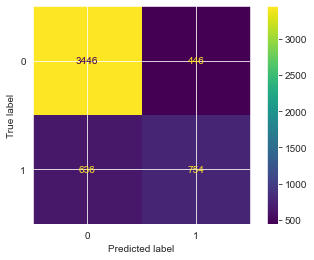

In [77]:
ConfusionMatrixDisplay(confusion_matrix(y_train, grid_result.predict(X_train_sub))).plot()

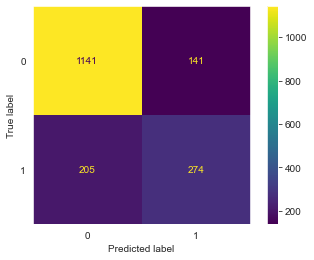

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
M = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(M).plot()
plt.grid(None)

NameError: name 'confu' is not defined

# Imports

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from IPython.display import clear_output

# Dictionary to store all our models.

models = dict()

# Set up our preprocessing and pipeline

scaler = RobustScaler()
encoder = OneHotEncoder(drop = "if_binary")

num_cols = make_column_selector(dtype_include = "number")
cat_cols = make_column_selector(dtype_include = "object")

preprocessing = make_column_transformer((scaler, num_cols),
                                        (encoder, cat_cols))

model = LogisticRegression(max_iter = 1000)

pipe = make_pipeline(preprocessing, model)

for num_of_feats in list(combinations.keys())[9:]:
    
    container = []
    progress = 0
    length = len(combinations[num_of_feats])
    
    for combination in combinations[num_of_feats]:
        
        progress+=1
        clear_output(wait=True)
        print(f"Working on combinations of {num_of_feats} features:\n\nTotal progress:\t{int(round(num_of_feats/len(combinations.keys())*100,0))}%")
        print(f"Sub-progress:\t{round(progress/length*100)}%")
        
        
        comb = list(combination)
        
        # Select subset of training/test data using a specific combination of features.
        
        X_train_sub = X_train[comb]
        X_test_sub = X_test[comb]
        
        # Fit data to model
        
        pipe.fit(X_train_sub, y_train)
        
        # Get and store scores
        
        y_true = y_test
        y_pred_sub = pipe.predict(X_test_sub)

        score_recall = recall_score(y_true, y_pred_sub)
        score_accuracy = accuracy_score(y_true, y_pred_sub)
        score_precision = precision_score(y_true, y_pred_sub)
        score_f1 = f1_score(y_true, y_pred_sub)
        score_roc = roc_auc_score(y_true, y_pred_sub)
        
        all_scores = {"recall" : score_recall,
                      "accuracy" : score_accuracy,
                      "precision" : score_precision,
                      "F1" : score_f1,
                      "ROC/AUC" : score_roc}
        
        # Append score and combination to our container
        
        container.append((score_recall, comb, all_scores))
        
    # Get the best score for n features
    
    best_combination = max(container, key = lambda x: x[0])
    
    # Add that score and corresponding combination to our model dictionary
    
    models[num_of_feats] = best_combination 

In [ ]:
for i in df.columns:
    print(i)